In [20]:
import tensorflow as tf
from tensorflow.keras import models ,layers
import matplotlib.pyplot as plt

In [21]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=40

In [22]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2154 files belonging to 3 classes.


In [23]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [24]:
len(dataset)

68

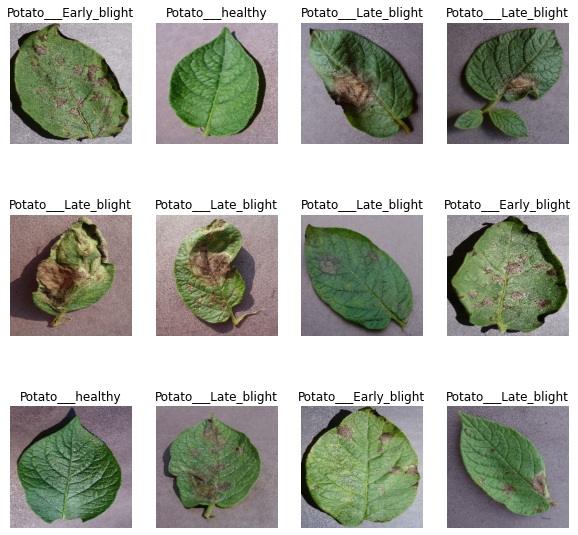

In [25]:
plt.figure(figsize=(10,10))
for image_batch ,label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [26]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
      ds_size=len(ds)
      if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
      train_size=int(train_split*ds_size)
      val_size=int(val_split*ds_size)
      train_ds=ds.take(train_size)
      val_ds=ds.skip(train_size).take(val_size)
      test_ds=ds.skip(train_size).skip(val_size)
      return train_ds ,val_ds ,test_ds

In [27]:
train_ds ,val_ds ,test_ds=get_dataset_partitions_tf(dataset)

In [28]:
len(train_ds) ,len(val_ds) ,len(test_ds)

(54, 6, 8)

In [29]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
resize_and_rescale=tf.keras.Sequential([
                     layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                     layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [31]:
data_augmentation=tf.keras.Sequential([
                      layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                      layers.experimental.preprocessing.RandomRotation(0.2),
])

In [32]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
                resize_and_rescale,
                data_augmentation,
                layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
                layers.MaxPooling2D((2,2)),
                layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
                layers.MaxPooling2D((2,2)),
                layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
                layers.MaxPooling2D((2,2)),
                layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
                layers.MaxPooling2D((2,2)),
                layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
                layers.MaxPooling2D((2,2)),
                layers.Flatten(),
                layers.Dense(64,activation='relu'),
                layers.Dense(3,activation='softmax')
])

model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
model.fit(
    train_ds,
    epochs=40,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/40
54/54 [==============================] - 77s 1s/step - loss: 0.8113 - accuracy: 0.5712 - val_loss: 0.7997 - val_accuracy: 0.6823
Epoch 2/40
54/54 [==============================] - 72s 1s/step - loss: 0.4818 - accuracy: 0.8125 - val_loss: 0.3809 - val_accuracy: 0.8438
Epoch 3/40
54/54 [==============================] - 72s 1s/step - loss: 0.3557 - accuracy: 0.8519 - val_loss: 0.4679 - val_accuracy: 0.8125
Epoch 4/40
54/54 [==============================] - 75s 1s/step - loss: 0.2670 - accuracy: 0.8987 - val_loss: 0.2647 - val_accuracy: 0.8854
Epoch 5/40
54/54 [==============================] - 71s 1s/step - loss: 0.2183 - accuracy: 0.9219 - val_loss: 0.3451 - val_accuracy: 0.8750
Epoch 6/40
54/54 [==============================] - 79s 1s/step - loss: 0.1976 - accuracy: 0.9294 - val_loss: 0.2512 - val_accuracy: 0.9115
Epoch 7/40
54/54 [==============================] - 85s 2s/step - loss: 0.1652 - accuracy: 0.9334 - val_loss: 0.1840 - val_accuracy: 0.9219
Epoch 8/40
54/54 [==

In [36]:
score=model.evaluate(test_ds)
score

8/8 [==============================] - 3s 247ms/step - loss: 0.0326 - accuracy: 0.9805


[0.03258310258388519, 0.98046875]

In [37]:
#acc=model['accuracy']
#val_acc=model.model['val_accuracy']

#loss=model.model['loss']
#val_loss=model.model['val_loss']

In [38]:
#plt.figure(figsize=(8,8))
#plt.subplot(1,2,1)
#plt.plot(range(EPOCHS),acc,label="Training accuracy")
#plt.plot(range(EPOCHS),val_acc,label="validation accuracy")
#plt.legend(loc='lower right')
#plt.title("Training and validation accuracy")

#plt.subplot(1,2,2)
#plt.plot(range(EPOCHS),loss,label="Training loss")
#plt.plot(range(EPOCHS),val_loss,label="validation loss")
#plt.legend(loc='upper right')
#plt.title("Training and validation loss")
#plt.show()

model.save("potato_model.h5", save_format='h5')

In [40]:
#tf.keras.models.load_model("potato_model.h5")